In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gc
from environments.custom_stock_env import StockEnvironment
from data_processing.feature_generation import FeatureGenerator
from data_processing.csv_reader import CSVReader
from data_processing.y_finance_reader import  YahooFinanceReader
import os

import sys

sys.path.append("C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research/")
sys.path.append("C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research/terminal")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
torch.cuda.is_available()

True

In [52]:
#ticker = "AAPL"
ticker_list = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "META", "TSLA"]

for ticker in ticker_list:
    yahoo_adjust_close = "Close"
    reader = YahooFinanceReader()
    stock = reader.read_stock_price_data(ticker)
    fg = FeatureGenerator(stock, task="custom", target_variable=yahoo_adjust_close)

    #fg._create_classes(period=prediction_period)
    fg.apply_IG_top_ten_indicators()

    data = fg.df

    for col in data.columns:
        if col in {"Open", "High", "Low", "Close"}:
            data[col.lower()] = data[col]
        elif col in {"Dividends", "Stock Splits"}:
            continue
        else:
            data["feature_" + col] = data[col]

    data.dropna(inplace=True)
    data = data[-1000:]
    data.to_pickle(f"C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research/raw_data/_{ticker}_last_3_years.pkl")

In [39]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,7 day simple moving average,7 day moving deviation,7 day lower bband,...,feature_returns,feature_gains,feature_loss,feature_7 day average gains,feature_7 day average loss,feature_7 day RSI,feature_26 day ema,feature_12 day ema,feature_26/12 macd,feature_26/12 macd 9 day signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-03 00:00:00-05:00,74.114704,76.353002,73.608106,75.176620,173788400,0.0000,0.0,76.941017,1.679541,73.581936,...,-0.002746,0.000000,0.002746,0.007032,0.011546,37.850349,74.765602,76.515517,1.749915,2.239827
2020-02-04 00:00:00-05:00,76.796280,77.850891,76.387105,77.658478,136616400,0.0000,0.0,76.959806,1.687903,73.584000,...,0.033014,0.033014,0.000000,0.011748,0.011134,51.341023,74.979889,76.691357,1.711468,2.134155
2020-02-05 00:00:00-05:00,78.795877,79.097894,77.682823,78.291718,118826800,0.0000,0.0,77.394731,1.560508,74.273715,...,0.008154,0.008154,0.000000,0.012913,0.006933,65.064224,75.225210,76.937566,1.712357,2.049795
2020-02-06 00:00:00-05:00,78.564500,79.209927,78.001881,79.207489,105425600,0.0000,0.0,77.656381,1.703801,74.248779,...,0.011697,0.011697,0.000000,0.010542,0.006933,60.325705,75.520193,77.286785,1.766592,1.993155
2020-02-07 00:00:00-05:00,78.702121,78.953581,77.635248,78.130844,117684000,0.1925,0.0,77.532845,1.619795,74.293255,...,-0.013593,0.000000,0.013593,0.007552,0.008875,45.972763,75.713575,77.416640,1.703066,1.935137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17 00:00:00-05:00,181.270004,182.929993,180.300003,182.679993,47317400,0.0000,0.0,184.958570,1.303272,182.352027,...,-0.005174,0.000000,0.005174,0.004518,0.003282,57.919133,187.778995,185.860569,-1.918426,-1.197745
2024-01-18 00:00:00-05:00,186.089996,189.139999,185.830002,188.630005,78005800,0.0000,0.0,185.397143,1.913217,181.570709,...,0.032571,0.032571,0.000000,0.005717,0.003282,63.527399,187.842033,186.286636,-1.555397,-1.269276
2024-01-19 00:00:00-05:00,189.330002,191.949997,188.820007,191.559998,68741000,0.0000,0.0,186.314285,2.999694,180.314896,...,0.015533,0.015533,0.000000,0.007936,0.002959,72.841044,188.117438,187.097922,-1.019515,-1.219324


In [26]:
# feat_gen  = FeatureGenerator(aapl, task="classification", target_variable="Close")
# X_train, X_test, y_train, y_test = feat_gen.create_modelling_data(features=["Close"], target="Profit")

In [5]:
from reinforcement_learning_tools.reinforcement_learning_dojo import RLDojo
from models.deep_q_agent import DQNAgent
from models.deep_dynaq_agent import DynaDQNAgent
from models.deep_dynaqplus_agent import DynaPlusDQNAgent
from models.linear_world_model import LinearWorldModel
from models.nn_world_model import NNWorldModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

c:\Users\YuweiZhu\anaconda3\envs\terminal\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [111]:
#env = gym.make("TradingEnv", df=data)

env = gym.make('MultiDatasetTradingEnv',
   dataset_dir = 'C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research/raw_data/*.pkl',
)

In [112]:
# agent = lambda obs, actions : DynaDQNAgent(obs, 
#                                        actions,
#                                        NNWorldModel(actions, obs, hidden_size=8),
#                                        double_dqn=True,
#                                        target_net_update="soft",
#                                        activation='gelu',
#                                        tau=0.001,
#                                        eps_decay_length=1000,
#                                        planning_steps=5,
#                                        gradient_clipping=100,
#                                        gradient_norm_clipping=-1)


# agent = lambda obs, actions : DynaDQNAgent(obs, 
#                                        actions,
#                                        LinearWorldModel(DecisionTreeRegressor, DecisionTreeClassifier),
#                                        double_dqn=True,
#                                        dyna_train_threshold=500,
#                                        target_net_update="soft",
#                                        activation='gelu',
#                                        tabular=False,
#                                        tau=0.001,
#                                        eps_decay_length=1000,
#                                        planning_steps=3,
#                                        gradient_clipping=100,
#                                        gradient_norm_clipping=-1)

agent = lambda obs, actions : DQNAgent(obs, 
                                       actions,
                                       double_dqn=True,
                                       target_net_update="soft",
                                       activation='gelu',
                                       eps_decay_length=1000,
                                       gradient_clipping=100,
                                       gradient_norm_clipping=-1)


dojo = RLDojo(agent)

In [9]:
agent = lambda obs, actions : DynaPlusDQNAgent(obs, 
                                       actions,
                                       LinearWorldModel(DecisionTreeRegressor, DecisionTreeClassifier),
                                       double_dqn=True,
                                       dyna_train_threshold=500,
                                       target_net_update="soft",
                                       activation='gelu',
                                       tabular=False,
                                       tau=0.001,
                                       eps_decay_length=1000,
                                       planning_steps=3,
                                       gradient_clipping=100,
                                       gradient_norm_clipping=-1)
dojo = RLDojo(agent)

In [10]:
dojo.train(plot=True, episodes=500)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

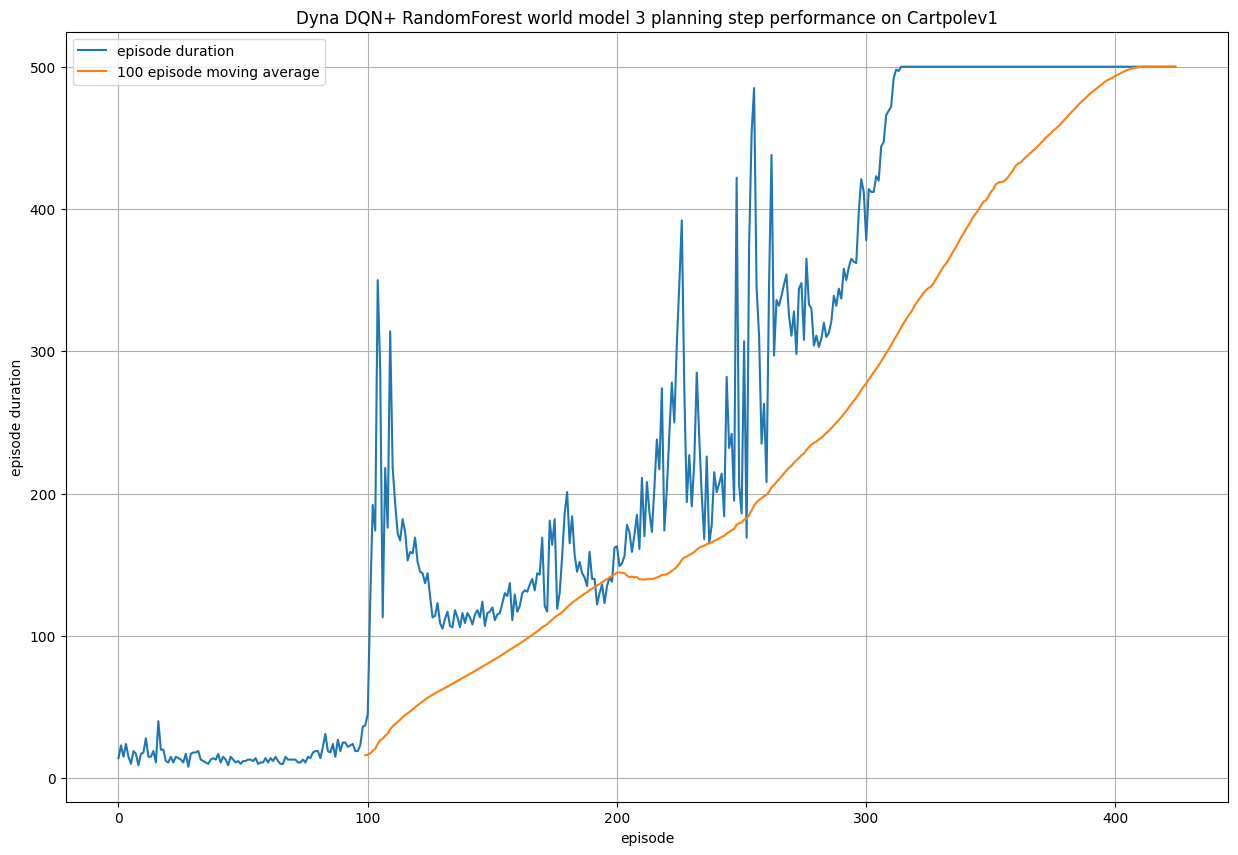

In [11]:
dojo.plot_final(title="Dyna DQN+ RandomForest world model 3 planning step performance on Cartpolev1")

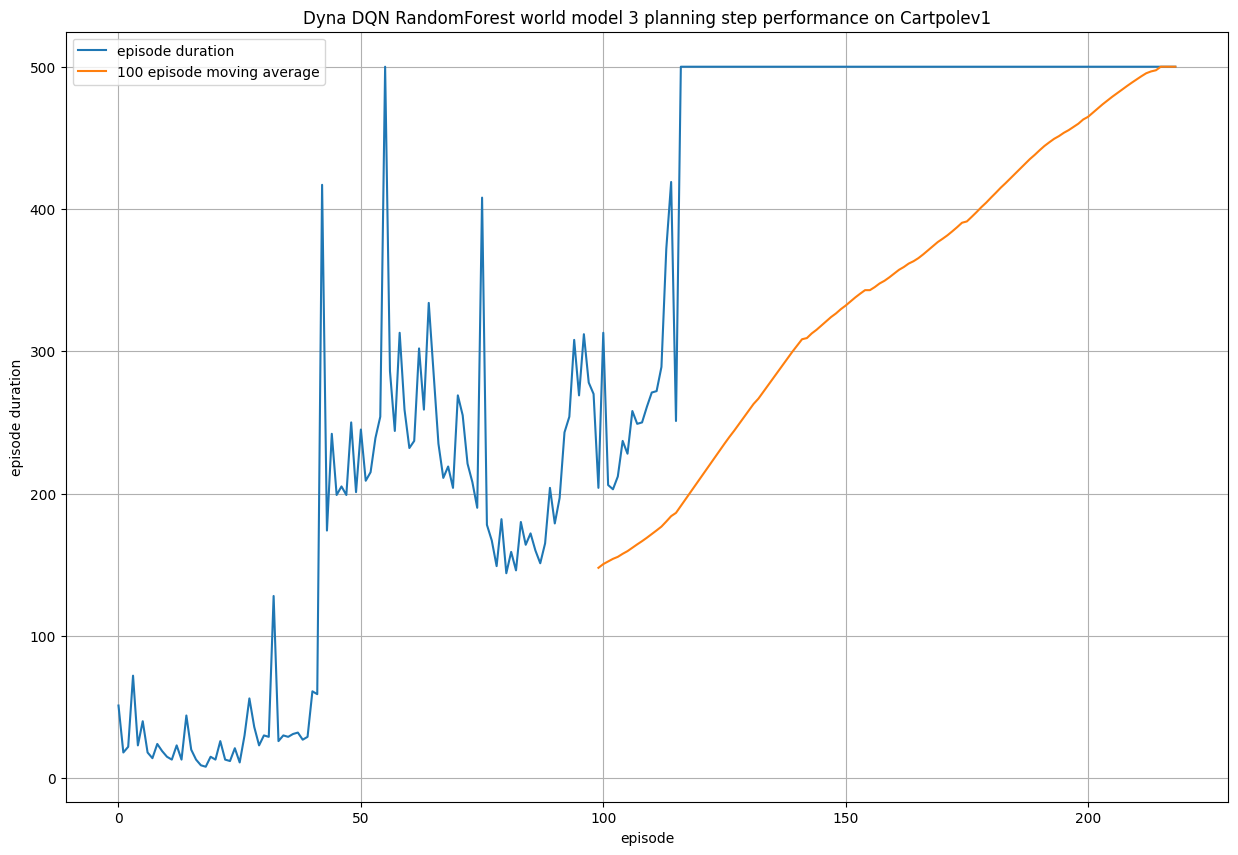

In [31]:
dojo.plot_final(title="Dyna DQN RandomForest world model 3 planning step performance on Cartpolev1")

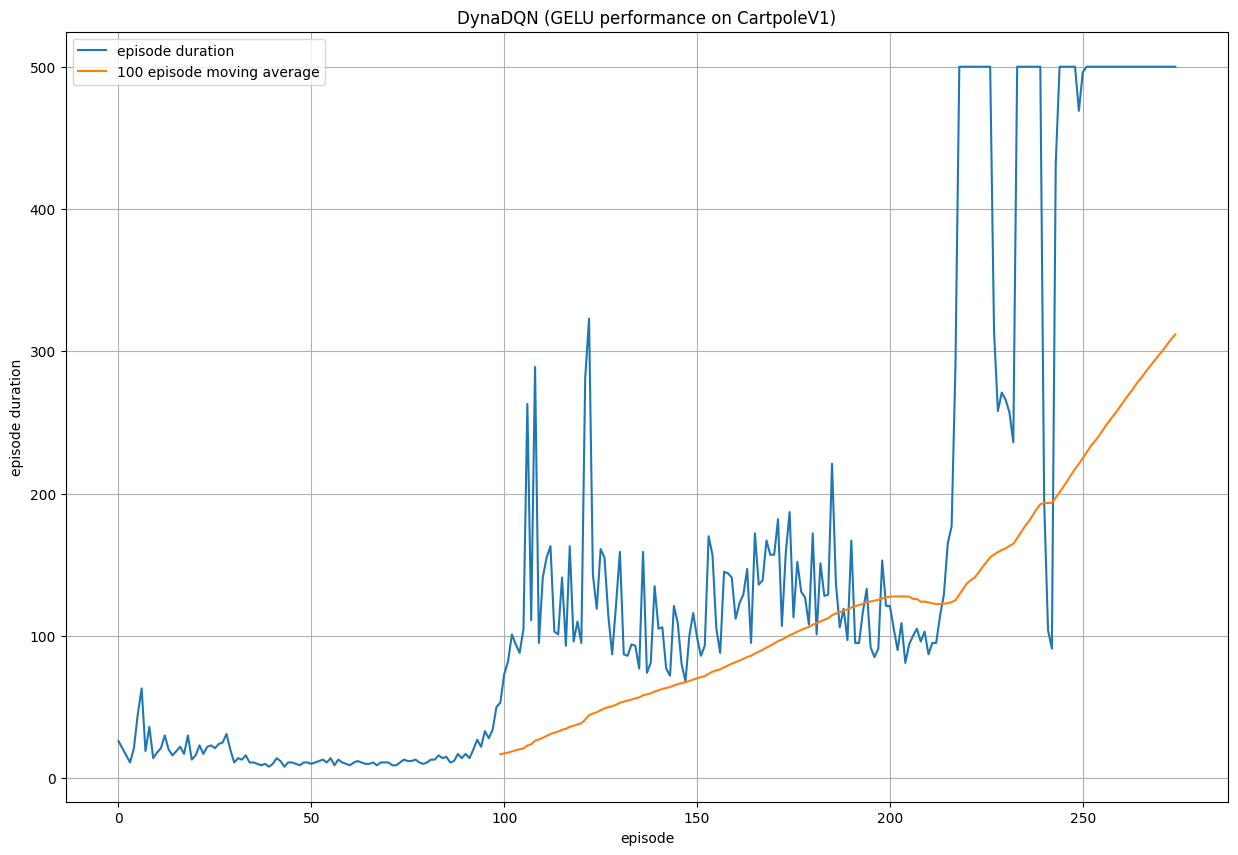

In [42]:
dojo.plot_final(title="DynaDQN (GELU performance on CartpoleV1)")

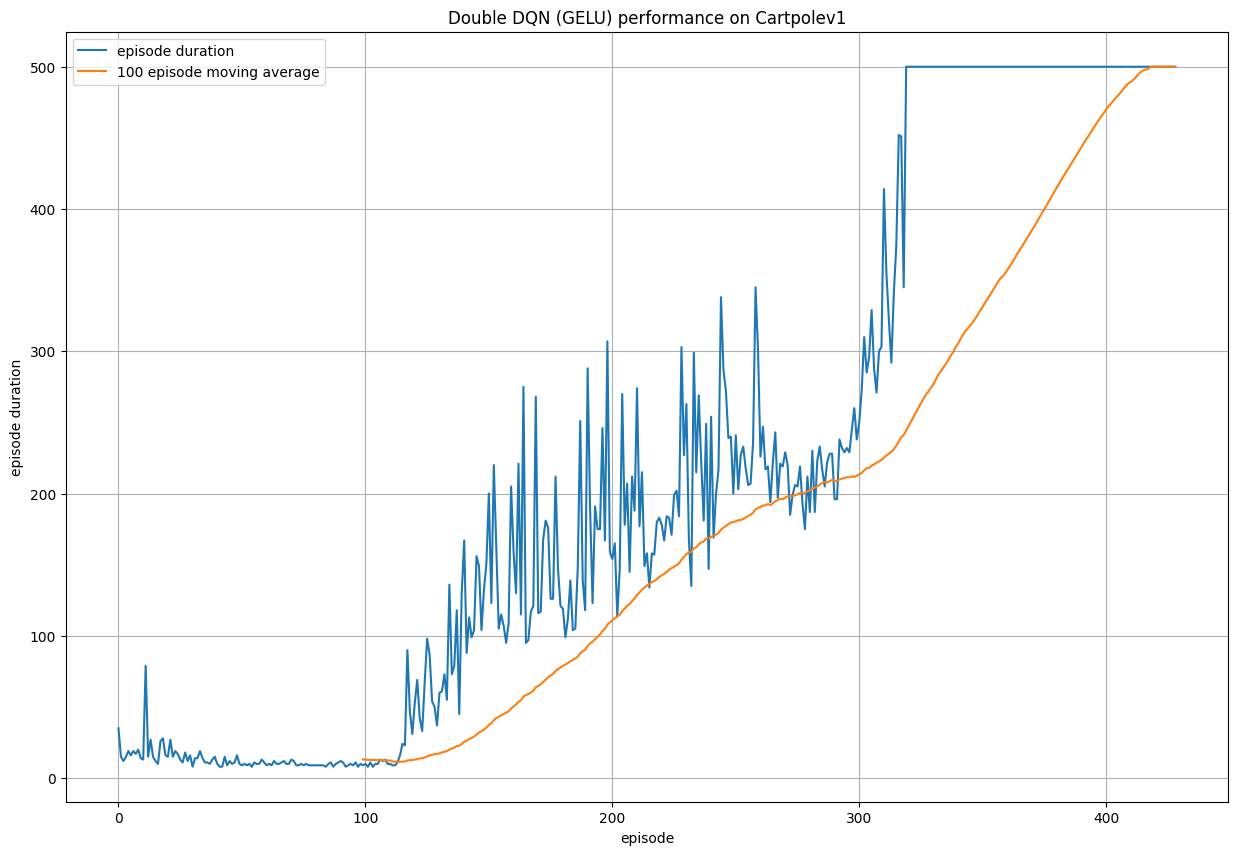

In [10]:
dojo.plot_final(title="Double DQN (GELU) performance on Cartpolev1")

In [12]:
dojo.environment.close(
    
)

# DQN Agent from personal library

In [55]:
from models.deep_q_agent import DQNAgent
from models.deep_dynaq_agent import DynaDQNAgent

In [45]:
ticker = "AAPL"

yahoo_adjust_close = "Close"
reader = YahooFinanceReader()
stock = reader.read_stock_price_data(ticker)
fg = FeatureGenerator(stock, task="custom", target_variable=yahoo_adjust_close)

#fg._create_classes(period=prediction_period)
fg.apply_IG_top_ten_indicators()

In [47]:
data = fg.df

for col in data.columns:
    if col in {"Open", "High", "Low", "Close"}:
        data[col.lower()] = data[col]
    elif col in {"Dividends", "Stock Splits"}:
        continue
    else:
        data["feature_" + col] = data[col]

In [50]:
data.dropna(inplace=True)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,7 day simple moving average,7 day moving deviation,7 day lower bband,...,feature_returns,feature_gains,feature_loss,feature_7 day average gains,feature_7 day average loss,feature_7 day RSI,feature_26 day ema,feature_12 day ema,feature_26/12 macd,feature_26/12 macd 9 day signal
Date,,,,,,,,,,,,,,,,,,,,,
1981-05-06 00:00:00-04:00,0.095001,0.095001,0.094569,0.094569,18950400,0.0,0.0,0.097036,0.001239,0.094558,...,-0.026665,0.000000,0.026665,0.002562,0.009451,21.328268,0.094621,0.096436,0.001815,0.002103
1981-05-07 00:00:00-04:00,0.095864,0.096296,0.095864,0.095864,9363200,0.0,0.0,0.096790,0.001282,0.094226,...,0.013698,0.013698,0.000000,0.004519,0.006967,39.344522,0.094713,0.096348,0.001635,0.002009
1981-05-08 00:00:00-04:00,0.096728,0.097160,0.096728,0.096728,7907200,0.0,0.0,0.096851,0.001264,0.094323,...,0.009008,0.009008,0.000000,0.005806,0.005071,53.380446,0.094863,0.096407,0.001544,0.001916
1981-05-11 00:00:00-04:00,0.095001,0.095001,0.094569,0.094569,11939200,0.0,0.0,0.096358,0.001398,0.093563,...,-0.022320,0.000000,0.022320,0.003244,0.008259,28.199197,0.094841,0.096124,0.001283,0.001790
1981-05-12 00:00:00-04:00,0.094569,0.095864,0.094569,0.094569,4256000,0.0,0.0,0.095864,0.001319,0.093226,...,0.000000,0.000000,0.000000,0.003244,0.008259,28.199197,0.094821,0.095885,0.001064,0.001645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20 00:00:00-05:00,196.899994,197.679993,194.830002,194.830002,52242800,0.0,0.0,196.572861,1.437019,193.698822,...,-0.010714,0.000000,0.010714,0.004390,0.003135,58.340685,191.739883,194.992142,3.252259,3.525587
2023-12-21 00:00:00-05:00,196.100006,197.080002,193.500000,194.679993,46482500,0.0,0.0,196.568573,1.443534,193.681505,...,-0.000770,0.000000,0.000770,0.003258,0.003245,50.105882,191.957669,194.944119,2.986450,3.417760
2023-12-22 00:00:00-05:00,195.179993,195.410004,192.970001,193.600006,37122800,0.0,0.0,195.945716,1.666503,192.612710,...,-0.005547,0.000000,0.005547,0.000874,0.004037,17.795708,192.079324,194.737333,2.658009,3.265809


In [51]:
data = data[-4000:]

In [57]:
agent = DQNAgent(double_dqn=True,
                    target_net_update='soft',
                    tau=0.005,
                    hard_update_interval=1000,
                    mem_length=10000,
                    eps_start=1.0,
                    eps_end=0.05,
                    eps_decay_length=1000,
                    environment='TradingEnv',
                    gradient_clipping=-1,
                    gradient_norm_clipping=1,
                    activation='gelu',
                    hidden_size_1=128,
                    hidden_size_2=128,
                    df=data)

<Figure size 640x480 with 0 Axes>

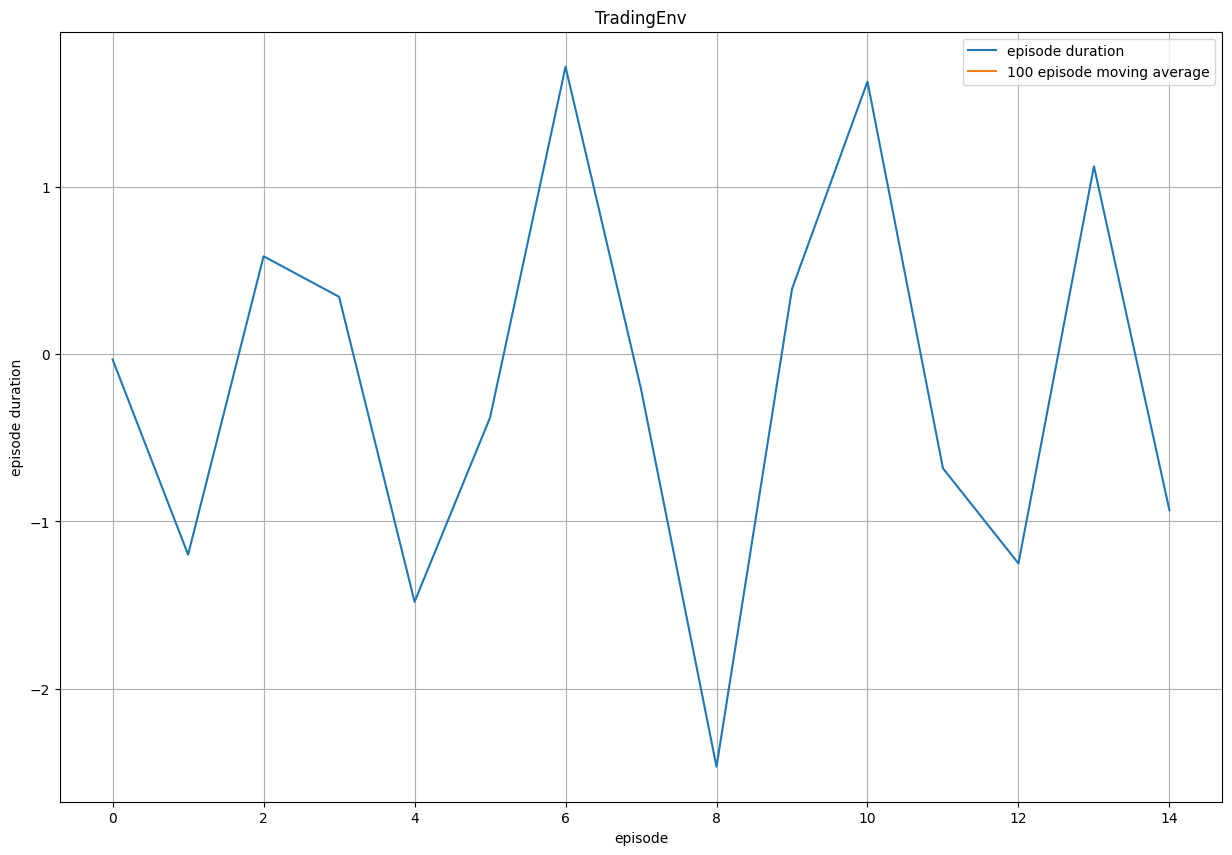

In [59]:
agent.train(episodes=15, plot=True)

In [10]:
agent.env.action_history

[0,
 0,
 1,
 0,
 0,
 -1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 -1,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [30]:
len(agent.env.action_history[-806:])

806

In [31]:
agent.env.action_history[:806]

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,

In [32]:
agent.env.close_prices.values

array([ 68.16212463,  68.2960968 ,  68.13291168,  68.20110321,
        68.0598526 ,  69.17047882,  69.23623657,  70.60990143,
        70.58311462,  71.00204468,  71.52082062,  73.15264893,
        72.44145966,  73.01868439,  72.67528534,  73.84434509,
        75.41287231,  75.58335114,  77.19815063,  76.15570831,
        75.8293457 ,  76.77922058,  77.62924194,  77.1031723 ,
        77.37840271,  77.7510376 ,  77.52695465,  75.24726105,
        77.37593079,  78.99560547,  78.88111115,  75.38365173,
        75.17662048,  77.65847778,  78.29171753,  79.2075119 ,
        78.13085938,  78.50196075,  78.02831268,  79.88134003,
        79.31246185,  79.33200836,  77.87939453,  79.00728607,
        78.19677734,  76.42679596,  72.7964859 ,  70.33071136,
        71.44641113,  66.7760849 ,  66.73703003,  72.95029449,
        70.63343811,  73.90973663,  71.51233673,  70.56265259,
        64.98170471,  69.66178131,  67.24239349,  60.60188293,
        67.86249542,  59.13219833,  61.73223114,  60.22

In [34]:
import plotly.express as px

fig = px.scatter(x=range(len(agent.env.close_prices)), y=agent.env.close_prices, color=agent.env.action_history[-806:])
fig.show()

In [86]:
act, opt = agent.test()

test score: 0.5900621118012422


In [87]:
mask = ~(act == 2)

In [88]:
mask

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,

In [89]:
act

array([1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 1,
       2, 2, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2,
       1, 2, 0, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 0,
       2, 1, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1,
       2, 1, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 0, 2,
       1, 0, 0, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       1, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2,
       2, 1, 2])

In [90]:
opt

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1])

In [91]:
length = len(agent.env.y_test)

In [92]:
reader = YahooFinanceReader()
price = reader.read_stock_price_data("AAPL")["Close"]

In [93]:
fig = px.scatter(x=np.array(range(length-1))[mask], y=np.array(price[-length+1:])[mask], color=(act==opt)[mask])
fig.show()

In [94]:
fig = px.scatter(x=np.array(range(length-1)), y=np.array(price[-length+1:]), color=act)
fig.show()

## Dyna DQN


In [7]:
# agent = DynaDQNAgent(double_dqn=True,
#                     planning_steps=1,
#                     target_net_update='soft',
#                     tau=0.001,
#                     hard_update_interval=1000,
#                     mem_length=10000,
#                     eps_start=1.0,
#                     eps_end=0.05,
#                     eps_decay_length=1000,
#                     environment='CartPole-v1', 
#                     gradient_clipping=100,
#                     gradient_norm_clipping = -1,
#                     activation='relu',
#                     hidden_size_1=128,
#                     hidden_size_2=128)

In [8]:
# agent.train()